# Trabalho Prático 1

## Horário Reuniões Startup   

### Análise ao Problema

Neste problema pretende-se construir um horário semanal para o plano de reuniões de projeto de uma “StartUp”.
Pretende-se alocar reuniões a salas, ao longo da semana, sendo o tempo de ocupação das salas de duas horas.

Existem P projetos, que vamos identificar por um índice $p\in[0..P-1]$, os quais são constituídos por um líder $\textbf(L)$ $l\in[0..L-1]$ e por colaboradores$\textbf(C)$ $c\in[0..C-1]$, e ainda, identificar cada sala $\textbf(S)$ disponível, a um dado tempo $\textbf(T)$ e a um dado dia $\textbf(D)$ , por um quintuplo $(l,c,s,t,d)$  $[0..L-1]\times[0..C-1]\in[0..S-1]\times[0..T-1]\times[0..D-1]$.

Usaremos uma família $x_{l,c,p,s,t,d}$ de variáveis binárias (ou seja, que assumem valores inteiros {0,1}), com a seguinte estrutura:
$$x_{l,c,p,s,t,d} == 1  \quad \mbox{se e só se} \quad \mbox{o projeto $p$ com um líder $l$ e colaboradores $c$ for alocado à sala $s$, no tempo $t$, no dia $d$.}$$


O problema tem como $\textbf{condicionantes}$ (que impõe limites máximos à alocação):

  1. Cada sala tem um e um só projeto num determinado slot.
  2. Para cada sala e para cada dia, o número de reuniões é menor ou igual que N.
  3. Cada colaborador tem, no máximo, um projeto num determinado slot.
  4. Cada projeto realiza, no máximo, R reuniões semanais.
  5. Cada projeto tem, no máximo, uma sala num determinado slot.
  6. Cada líder tem, no máximo, um projeto.
  
    
A questão tem como $\textbf{obrigações}$ (que impõe limites mínimos à alocação):

  7. O líder do projeto participa em todas as reuniões do seu projeto.
  8. Cada reunião tem pelo menos 50% do número de colaboradores.
  9. Para cada sala, o tempo disponível é entre 0 e T.
  10. Cada líder tem um dia da semana em que não está disponível.
  11. Cada colaborador tem um dia da semana em que não está disponível.
  12. Uma reunião só acontece se a disponibilidade do líder e dos colaboradores coincidirem.

In [1]:
from pyscipopt import Model, quicksum
import random

In [2]:
horario = Model()

### Inputs

Começámos por definir algumas variáveis importantes, tais como, o número de salas existentes, o número de dias úteis numa semana, o tempo possível para cada reunião, o tempo disponível de cada sala, o número máximo de colaboradores por projeto (10 -> 9 colaboradores + 1 líder) e ainda, o número de projetos que será igual ao número de líderes.

In [3]:
# salas existentes
S = 4

# dias da semana
D = 5

# tempo de reunião de um projeto (2 horas)
periodo = 2

# tempo disponível sala
T = 8

# número de projetos
P = 10

# colaboradores + lider
C = 10 

# número de líderes é igual ao numero de projetos
L = 10

# número máximo de reuniões semanais, para cada projeto
# ((T/periodo)*D*S)/P
R = 5

# número máximo de reuniões de uma sala num dia
N = T / periodo

In [4]:
# declaração da matriz de alocação X como um dicionário.

X = {}
for p in range(P):
    for l in range(L):
        for c in range(C):
            for s in range(S):
                for t in range(T):
                    for d in range(D):
                        X[p,l,c,s,t,d] = horario.addVar((str(p)+'_'+str(l)+'_'+str(c)+'_'+str(s)+'_'+str(t)+'_'+str(d)), vtype="I")
                        horario.addCons(0<=X[p,l,c,s,t,d])
                        horario.addCons(X[p,l,c,s,t,d]<=1)


Apresentamos agora as restrições do problema.

1. Cada sala tem um e um só projeto num determinado slot

$$\forall_{s< S} \cdot \forall_{d<D} \cdot \forall_{t<T}\quad \sum_{p < P} x_{p,l,c,s,t,d} \leq 1$$

In [5]:
for s in range(S):
    for d in range(D):
        for t in range(T):
            horario.addCons(quicksum([X[p,l,c,s,t,d] for p in range(P)]) <= 1)

2. Para cada sala e para cada dia, o número de reuniões é menor ou igual que N.

$$\forall_{s<S} \cdot \forall_{d<D} \cdot \quad \sum_{p<P} x_{p,l,c,s,t,d} \leq N$$

In [6]:
for s in range(S):
    for d in range(D):
        horario.addCons(quicksum([X[p,l,c,s,t,d] for p in range(P)]) <= N)

3. Cada colaborador tem, no máximo, um projeto num determinado slot.

$$\forall_{c<C} \cdot \forall_{t<T} \cdot \forall_{d<D} \cdot \quad \sum_{p<P} x_{p,l,c,s,t,d} <= 1$$

In [7]:
for c in range(C):
    for t in range(T):
        for d in range(D):
            horario.addCons(quicksum([X[p,l,c,s,t,d] for p in range(P)]) <= 1)


4. Cada projeto realiza, no máximo, R reuniões semanais.
$$\quad \sum_{p<P} x_{p,l,c,s,t,d} <= R$$

In [8]:
horario.addCons(quicksum([X[p,l,c,s,t,d] for p in range(P)]) <= R)

c320581

5. Cada projeto tem, no máximo, uma sala num determinado slot.

$$\forall_{p<P} \cdot \forall_{t<T} \cdot \forall_{d<D} \quad \sum_{s<S} x_{p,l,c,s,t,d} <= 1$$

In [9]:
for p in range(P):
    for d in range(D): 
        for t in range(T):
            horario.addCons(quicksum([X[p,l,c,s,t,d] for s in range(S)])<=1)

6. Cada líder tem, no máximo, um projeto

$$\forall_{l<L} \quad \sum_{p<P} x_{p,l,c,s,t,d} <= 1$$ 

In [10]:
for l in range(L):
    horario.addCons(quicksum([X[p,l,c,s,t,d] for p in range(P)])<=1)

7. O líder do projeto participa em todas as reuniões do seu projeto

$$\forall_{p<P} \cdot \quad \sum_{l<L} x_{p,l,c,s,t,d} = 1$$

In [11]:

for p in range(P):
    horario.addCons(quicksum([X[p,l,c,s,t,d] for l in range(L)]) == 1)


8. Cada reunião tem pelo menos 50% do número de colaboradores. 

$$\forall_{p<P} \cdot \quad \sum_{c<C} x_{p,l,c,s,t,d} \geq C/2$$

In [12]:
'''
for p in range(P):
    horario.addCons(quicksum([X[p,l,c,s,t,d] for c in range(C)]) >= 0.5*C)
'''

'\nfor p in range(P):\n    horario.addCons(quicksum([X[p,l,c,s,t,d] for c in range(C)]) >= 0.5*C)\n'

9. Para cada sala, o tempo disponível é entre 0 e T.
$$\forall_{s<S}, 0 \leq \quad \sum_{d<D, t<T} \leq T$$

In [13]:

for s in range(S):
    horario.addCons(quicksum([X[p,l,c,s,t,d]   for t in range(T) for d in range(D)])>= 0)
    horario.addCons(quicksum([X[p,l,c,s,t,d]   for t in range(T) for d in range(D)])<= T)


10. Cada líder tem um dia da semana em que não está disponível.
Para implementar esta condição, acrescentamos uma família de variáveis binárias $y_{l,d}$ que indicam se o líder $l$ está disponível no dia $d$, restringindo o número máximo de dias, dos quais o líder está disponível.

$$\forall_{l<L} \cdot \quad \sum_{d<D} y_{l,d} < D$$

In [14]:

y = {}
for l in range(L):
    for d in range(D):
        y[l,d] = horario.addVar(str(l)+'_'+str(d), vtype="I")
        horario.addCons(0 <= y[l,d])
        horario.addCons(y[l,d] <= 1)

for l in range(L):
    horario.addCons(quicksum([y[l,d] for d in range(D)]) <= D-1)


11. Cada colaborador tem um dia da semana em que não está disponível.
Para implementar esta condição, acrescentamos uma família de variáveis binárias $z_{c,d}$ que indicam se o colaborador $c$ está disponível no dia $d$, restringindo o número máximo de dias, dos quais o colaborador está disponível.

$$\forall_{c<C} \cdot \quad \sum_{d<D} z_{c,d} < D$$

In [15]:

z = {}
for c in range(C):
    for d in range(D):
        z[c,d] = horario.addVar(str(c)+'_'+str(d), vtype="I")
        horario.addCons(0 <= z[c,d])
        horario.addCons(z[c,d] <= 1)
for c in range(C):
    horario.addCons(quicksum([z[c,d] for d in range(D)]) <= D-1)


12. Uma reunião só acontece se a disponibilidade do líder e dos colaboradores coincidirem.
$$\forall_{p<P} \cdot \forall_{d<D} \cdot \quad \sum_{s<S,\,t<T} x_{p,l,c,s,t,d} \leq R * y_{l,d} * z_{c,d}$$

In [16]:

for p in range(P):
    for d in range(D):
        horario.addCons(quicksum([X[p,l,c,s,t,d] for s in range(S) for t in range(T)]) <= R*y[l,d]*z[c,d])


In [17]:

horario.optimize()

status = horario.getStatus()
sol = {}
if status == 'optimal':
    for p in range(P):
        for l in range(L):
            for c in range(C):
                for s in range(S):
                    for t in range(T):
                        for d in range(D):
                            if horario.getVal(X[p,l,c,s,t,d]) == 1:
                                sol[p,l,c,s,t,d] = X[p,l,c,s,t,d]
    print(len(sol))
    for p in sol:
        print(p)
        
else:
    print("Não há solução!")

10
(0, 7, 9, 3, 7, 4)
(1, 0, 9, 3, 7, 4)
(2, 6, 9, 3, 7, 4)
(3, 1, 9, 3, 7, 4)
(4, 2, 9, 3, 7, 4)
(5, 3, 9, 3, 7, 4)
(6, 4, 9, 3, 7, 4)
(7, 5, 9, 3, 7, 4)
(8, 9, 9, 3, 7, 4)
(9, 8, 9, 3, 7, 4)


## "Pigeon Hole Principle" (PHP)

### Lógica Proposicional

Nós queremos recriar o problema clássico da complexidade "Pigeon Hole Principle" na linguagem SMT. Uma linguagem SMT (Satisfiability Model Theory) é caraterizada da seguinte forma: 
- f é satisfazível (SAT) se e só se existir uma valoração que torne f verdadeira; 
- f é válida (VAL) se e só se toda a valoração torna f verdade.

Para formalizar o princípio, vamos introduzir variáveis booleanas $x_{p,pol}$ interpretada como:

* $x_{p,pol} = 1$ se e só se o p-ésimo pombo ocupa o pol-ésimo poleiro.

Seja $PHP_{N-1}^{N}$ definida pelas seguintes cláusulas:

   1. O pombo p tem pelo menos um poleiro;
   
   $$\forall_{p}\bigwedge_{pol=0}^{N-1} x_{p,pol}$$

   2. Um pombo p não pode ter mais do que um poleiro.
   
   $$\forall_{p}\bigwedge_{pol=0}^{N-1} (x_{p,pol} \rightarrow (\bigwedge_{pol2=pol+1}^{N-1} \neg x_{p,pol2})$$

   3. Um poleiro não pode ter mais do que um pombo

   Para um dado poleiro $pol$, e pombos $p$ e $k$, se $pol$ estiver a ser ocupado por $p$ e $k$, então $p$ e $k$ são o mesmo pombo. 
   
   $$x_{p,pol} \wedge x_{k, pol} \rightarrow p = k$$

In [18]:
from z3 import *
from timeit import timeit
import matplotlib.pyplot as plt

In [19]:
# N = número de pombos
def verifica(n):
    # dicionario de alocação pombo poleiro
    aloc = {}
    
    # todo o pombo tem pelo menos um poleiro
    for pombo in range(n):
        aloc[pombo] = {}
        for poleiro in range(n-1):
            aloc[pombo][poleiro] = Bool(str(pombo)+"_"+str(poleiro))
    
    # inicializar o solver
    s = Solver()
    
    # no minimo um pombo num poleiro
    for pombo in aloc:
        s.add(Or(list(aloc[pombo].values())))
    
    
    
    # no máximo um pombo por poleiro
    # vai distribuir um pombo por um e um só poleiro
    for pombo in aloc:
        for poleiro in range(n-1):
            for poleiro2 in range(n-1):
                if poleiro != poleiro2:
                    s.add(Implies(aloc[pombo][poleiro], Not(aloc[pombo][poleiro2])))

        # os restantes pombos (x) não podem estar no mesmo poleiro do pombo
        for pombo in aloc:
            for poleiro in range(0, n-1):
                for x in range(pombo+1,n):  
                    #print("outro pombo" + str(x))
                    s.add(Implies(aloc[pombo][poleiro], Not(aloc[x][poleiro])))
    #print(s)              
    if s.check() == sat:
        m = s.model()
        #print(m)
        return True
    else:
        return False


### Espaço de resultados:

[(2, 6.259999736357713e-07), (3, 3.220000053261174e-07), (4, 3.020000463038741e-07), (5, 2.5699995376271545e-07), (6, 2.780000158963958e-07), (7, 2.4700000267330324e-07), (8, 3.229999947507167e-07), (9, 2.079999603665783e-07)]


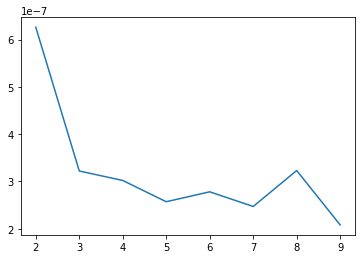

In [20]:

l = []

for n in range(2,10):
    x = timeit(setup="from __main__ import verifica", \
       stmt="verifica",number=1)
    l.append((n,x))
print(l)
zip(*l)
plt.plot(*zip(*l))
plt.show()



Neste problema é impossível alocar N pombos em N-1 poleiros sendo que, cada pombo ocupa totalmente um poleiro.

### Lógica Inteira Linear

Outro método para solucionar o problema de decisão consiste na aplicação da Lógica Inteira Linear. Com o objetivo de alcançar a conclusão desejada, criámos um dicionário aloc onde associámos uma variável inteira para cada pombo a um único poleiro. Inicialmente restringimos os valores dos poleiros para obter poleiros válidos (de 0 até n-1, onde n é o número total de pombos).
$$
0 \le pombo_{pol} < n-1
$$

Em seguida, elaboramos também uma última restrição de forma a não ser possível haver mais do que um pombo no mesmo poleiro.

$$
pombo_{pol1} \neq pombo_{pol2}
$$

In [21]:
def verifica_inteiro(n):
    # z3 solver
    
    s = Solver()
    
    aloc = {}
    for pombo in range(n):                # cria as variáveis z3
        aloc[pombo] = Int(str(pombo))
        s.add(0 <= aloc[pombo], aloc[pombo] < n-1) # poleiro válido
        
    for pombo in aloc:
        for pombo2 in aloc:
            if pombo != pombo2:
                s.add(aloc[pombo] != aloc[pombo2])
    
    if s.check() == sat:
        m = s.model()
        print(m)
        return True
    else:
        return False
    

### Espaço de resultados:

In [22]:

for n in range(2,10):
    print(verifica_inteiro(n))
    

False
False
False
False
False
False
False
False


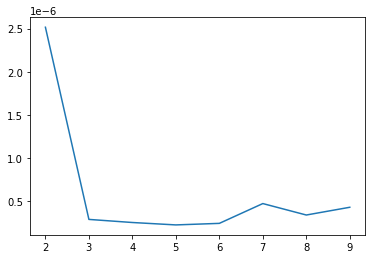

In [23]:
l = []

for n in range(2,10):
    x = timeit(setup="from __main__ import verifica_inteiro", \
       stmt="verifica_inteiro",number=1)
    l.append((n,x))
#print(l)
zip(*l)
plt.plot(*zip(*l))
plt.show()


## Análise de Complexidade

Após a resolução do exercíco 2, pudemos concluis que existem diferenças entre a lógica proposicional e a lógica inteira linear.
No que toca à execução, na lógica proposional realizamos o trabalho de acordo com algumas restrições, sendo essas:

    1) todos os pombos têm pelo menos um poleiro.
    2) Um pombo tem um e um só poleiro.
    3) Um poleiro não pode ter mais do que um pombo.

Após essas restrições obtemos a resolução do problema recorrendo ao Z3.
Na lógica inteira linear optamos por distribuir os pombos pelos poleiros, ou seja, o pombo1 no poleiro1 e assim sucessivamente.

Com isto concluimos que a programação linear inteira pode ser executada muito mais rapidamente e também nos dá resolução exata para muitos problemas.


# Bibliografia

1. https://members.loria.fr/SMerz/papers/cade2011symmetry.pdf (Pigeon Hole Principle)
2. https://homepages.cwi.nl/~rdewolf/resolutionlowerbound.pdf (Pigeon Hole Principle)